# UK Electric Vehicle Uptake

Story:
- Exploratory analysis
- Problem
- Answer to problem

The UK Government has published an account of all registered vehicles, according to their type (bus, car, etc), location, fuel type and ownership type (business, private).

This information can be used to assess the uptake of electric vehicles (EVs), be it by vehicle type, location, etc across the UK over time.

The datasets can be found [here](https://www.gov.uk/government/statistical-data-sets/vehicle-licensing-statistics-data-tables). There are numerous, and for this research we will use VEH0105, focused on fossil fuel (FF) vehicles, and VEH0142, which looks at EVs.

In [1]:
import pandas as pd
import numpy as np
import regex as re

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Importing the data

ev = pd.read_csv('EVs_from_veh0142.csv')

In [3]:
ev.head()

,Units,BodyType,Fuel,Keepership [note 3],ONS Sort [note 6],ONS Code [note 6],ONS Geography [note 6],2022 Q3,2022 Q2,2022 Q1,...,2012 Q1,2011 Q4,2011 Q3,2011 Q2,2011 Q1,2010 Q4,2010 Q3,2010 Q2,2010 Q1,2009 Q4
0,Number,Buses and coaches,Battery electric,Company,1,K02000001,United Kingdom,"1,808","1,707","1,572",...,[x],[x],[x],[x],[x],[x],[x],[x],[x],[x]
1,Number,Buses and coaches,Battery electric,Company,2,K03000001,Great Britain,"1,702","1,602","1,513",...,54,58,57,59,58,49,45,41,40,38
2,Number,Buses and coaches,Battery electric,Company,3,E92000001,England,"1,343","1,249","1,194",...,51,55,54,57,55,46,43,39,38,36
3,Number,Buses and coaches,Battery electric,Company,4,E12000001,North East,21,12,12,...,7,12,12,13,14,7,5,[c],[c],[c]
4,Number,Buses and coaches,Battery electric,Company,5,E06000047,County Durham,[c],[c],[c],...,0,0,[c],[c],[c],[c],[c],0,0,0


Let's take a look at these columns. We have:

In [4]:
print(ev.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33059 entries, 0 to 33058
Data columns (total 59 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Units                   33059 non-null  object
 1   BodyType                33059 non-null  object
 2   Fuel                    33059 non-null  object
 3   Keepership [note 3]     33059 non-null  object
 4   ONS Sort [note 6]       33059 non-null  int64 
 5   ONS Code [note 6]       33059 non-null  object
 6   ONS Geography [note 6]  33059 non-null  object
 7   2022 Q3                 33059 non-null  object
 8   2022 Q2                 33059 non-null  object
 9   2022 Q1                 33059 non-null  object
 10  2021 Q4                 33059 non-null  object
 11  2021 Q3                 33059 non-null  object
 12  2021 Q2                 33059 non-null  object
 13  2021 Q1                 33059 non-null  object
 14  2020 Q4                 33059 non-null  object
 15  20

In [5]:
print('Values in "Units" column = \n' + str(ev['Units'].value_counts()))
print('\nValues in "BodyType" column = \n' + str(ev['BodyType'].value_counts()))
print('\nValues in "Fuel" column = \n' + str(ev['Fuel'].value_counts()))
print('\nValues in "Keepership" column = \n' + str(ev['Keepership [note 3]'].value_counts()))

Values in "Units" column = 
Number    33059
Name: Units, dtype: int64

Values in "BodyType" column = 
Total                   6702
Cars                    6697
Light goods vehicles    6024
Other vehicles          5112
Motorcycles             3424
Buses and coaches       2556
Heavy goods vehicles    2544
Name: BodyType, dtype: int64

Values in "Fuel" column = 
Total                               9196
Battery electric                    9177
Plug-in hybrid electric (petrol)    6112
Range extended electric             5146
Plug-in hybrid electric (diesel)    3428
Name: Fuel, dtype: int64

Values in "Keepership" column = 
Total      11366
Private    10890
Company    10803
Name: Keepership [note 3], dtype: int64


#### So we have the following columns:
- **Units:** only in 'number', keeps things easy.
- **BodyType:** the type of vehicle, e.g. car, bus, motorcycle, etc.
- **Fuel**: the type of electric vehicle fuel type.
- **Keepership**: whether owned by a private individual or a company.
- **ONS Sort:** Office of National Statistics sorting field.
- **ONS Code:** Office of National Statistics code for the local authority that the vehicle is registered to
- **ONS Geography**: Office of National Statistics local authority name in plain English. Denotes where the vehicle is registered.
- **Columns 7-58**: the number of EVs registered each quarter, between Q4 2009 and Q3 2022.


Every column seems to come with a 'Total' row of its own, as well as a count by their unique breakdowns.


#### Some notes from the dataset:
- Quarters follow the calendar year, so:<br>Q1 = end of March<br>Q2 = end of June<br>Q3 = end of September<br>Q4 = end of December
<br><br>
- Keepership refers to the registered keeper of the vehicle, which might not be the owner.
<br><br>
- Vehicles are allocated to a local authority according to the postcode of the registered keeper. This is the keeper's address for privately owned vehicles or the company's registered address for company owned vehicles. The address does not necessarily reflect where the vehicle is located. This is especially true for large fleets kept by companies involved with vehicle management, leasing or rentals. Significant changes in the number of vehicles from year to year can often occur when these companies change their registered address.
<br><br>
- The exact geographical location of a vehicle registration cannot always be allocated due to the postcode being incomplete or invalid. <i>We might see this in the data, where the overarching local authority appears to have more vehicles registered than the underlying regions within it would account for</i>


Now that we have an understanding of the data available, lets do some cleaning and exploration.

## Data Cleaning

Tasks:
- Remove [note X] from column names
- Change columns to lowercase and snake case as appropriate
- Check for null values and remove
- Convert numeric columns to integers

In [6]:
#Cleaning column names 

cols_list = ev.columns.to_list()
new_cols = []

for item in cols_list:
    #removes spaces
    item = item.replace(' ','')
    #snake_case instead of camel case
    item = re.sub(r'(?<=[a-zA-Z0-9]{3})(?=[A-Z])','_', item)
    #lowercase
    item = item.lower()
    #remove [noteX]
    item = re.sub(r'\[[^\]]*\]', '', item)
    new_cols.append(item)

ev.columns = new_cols

In [7]:
ev.head()

,units,body_type,fuel,keepership,ons_sort,ons_code,ons_geography,2022_q3,2022_q2,2022_q1,...,2012_q1,2011_q4,2011_q3,2011_q2,2011_q1,2010_q4,2010_q3,2010_q2,2010_q1,2009_q4
0,Number,Buses and coaches,Battery electric,Company,1,K02000001,United Kingdom,"1,808","1,707","1,572",...,[x],[x],[x],[x],[x],[x],[x],[x],[x],[x]
1,Number,Buses and coaches,Battery electric,Company,2,K03000001,Great Britain,"1,702","1,602","1,513",...,54,58,57,59,58,49,45,41,40,38
2,Number,Buses and coaches,Battery electric,Company,3,E92000001,England,"1,343","1,249","1,194",...,51,55,54,57,55,46,43,39,38,36
3,Number,Buses and coaches,Battery electric,Company,4,E12000001,North East,21,12,12,...,7,12,12,13,14,7,5,[c],[c],[c]
4,Number,Buses and coaches,Battery electric,Company,5,E06000047,County Durham,[c],[c],[c],...,0,0,[c],[c],[c],[c],[c],0,0,0


So we have 0 null values according to ev.info(), however ev.head() makes it clear that there are some non-integers. E.g. we can see [c] and [x] appearing here and there. Will replace them with nulls and convert the columns to integers

In [8]:
#Columns 7-58, all rows
ev.iloc[:,7:] = ev.iloc[:,7:].replace('[x]', np.NaN)
ev.iloc[:,7:] = ev.iloc[:,7:].replace('[c]', np.NaN)
ev.iloc[:,7:] = ev.iloc[:,7:].replace(',','', regex=True)
ev.iloc[:,7:] = ev.iloc[:,7:].astype(float)

/var/folders/jb/5csh6qnx4y7brg28_7d39qyw0000gq/T/ipykernel_33291/3490987676.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ev.iloc[:,7:] = ev.iloc[:,7:].astype(float)


In [9]:
ev

,units,body_type,fuel,keepership,ons_sort,ons_code,ons_geography,2022_q3,2022_q2,2022_q1,...,2012_q1,2011_q4,2011_q3,2011_q2,2011_q1,2010_q4,2010_q3,2010_q2,2010_q1,2009_q4
0,Number,Buses and coaches,Battery electric,Company,1,K02000001,United Kingdom,1808.0,1707.0,1572.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Number,Buses and coaches,Battery electric,Company,2,K03000001,Great Britain,1702.0,1602.0,1513.0,...,54.0,58.0,57.0,59.0,58.0,49.0,45.0,41.0,40.0,38.0
2,Number,Buses and coaches,Battery electric,Company,3,E92000001,England,1343.0,1249.0,1194.0,...,51.0,55.0,54.0,57.0,55.0,46.0,43.0,39.0,38.0,36.0
3,Number,Buses and coaches,Battery electric,Company,4,E12000001,North East,21.0,12.0,12.0,...,7.0,12.0,12.0,13.0,14.0,7.0,5.0,NaN,NaN,NaN
4,Number,Buses and coaches,Battery electric,Company,5,E06000047,County Durham,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33054,Number,Total,Total,Total,460,N09000010,"Newry, Mourne and Down",693.0,612.0,537.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33055,Number,Total,Total,Total,461,[z],Local Authority unknown within Northern Ire...,761.0,657.0,597.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33056,Number,Total,Total,Total,462,[z],"Vehicle under disposal, previously GB",15301.0,11780.0,9500.0,...,326.0,206.0,200.0,304.0,218.0,151.0,142.0,192.0,133.0,131.0
33057,Number,Total,Total,Total,463,[z],"Vehicle under disposal, previously NI",191.0,117.0,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Exploratory Analysis

In [10]:
#Initial peek into the numeric data below

pd.options.display.float_format = '{:.2f}'.format
ev.iloc[:,7:].describe()

,2022_q3,2022_q2,2022_q1,2021_q4,2021_q3,2021_q2,2021_q1,2020_q4,2020_q3,2020_q2,...,2012_q1,2011_q4,2011_q3,2011_q2,2011_q1,2010_q4,2010_q3,2010_q2,2010_q1,2009_q4
count,27865.00,27944.00,28000.00,27939.00,27788.00,27756.00,27666.00,27560.00,27438.00,27451.00,...,26770.00,26779.00,26825.00,26815.00,26907.00,26910.00,26890.00,26849.00,26907.00,26909.00
mean,1554.05,1426.39,1304.30,1155.80,1014.42,890.06,772.37,686.60,590.60,498.00,...,12.05,11.81,11.72,11.57,11.22,10.72,10.64,10.91,10.75,10.63
std,21132.07,19380.05,17695.68,15664.82,13643.65,11943.15,10323.60,9129.50,7787.95,6576.56,...,162.93,159.58,158.31,157.38,153.91,148.72,147.77,152.63,151.02,150.04
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,13.00,12.00,11.00,10.00,9.00,8.00,7.00,7.00,6.00,5.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,192.00,175.00,157.00,140.00,125.25,112.00,99.00,90.00,80.00,69.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1003072.00,921905.00,843238.00,747895.00,651316.00,570527.00,493138.00,435499.00,371756.00,314133.00,...,9158.00,8869.00,8787.00,8717.00,8393.00,7980.00,7911.00,8118.00,7990.00,7897.00


We can see from the Max and Mean rows that the number of EVs in the UK grows significantly between 2009 and 2022. The min column tells us that there are regions that still have 0 EVs too. Let's take a closer look.

In [11]:
print(ev['ons_geography'].unique())

['United Kingdom' 'Great Britain' 'England' 'North East'
 '   County Durham' '   Darlington' '   Hartlepool' '   Middlesbrough'
 '   Northumberland' '   Redcar and Cleveland' '   Stockton-on-Tees'
 '   Tyne and Wear (Met County)' '      Gateshead'
 '      Newcastle upon Tyne' '      North Tyneside' '      South Tyneside'
 '      Sunderland' '   Local Authority unknown within North East'
 'North West' '   Blackburn with Darwen' '   Blackpool' '   Cheshire East'
 '   Cheshire West and Chester' '   Halton' '   Warrington' '   Cumbria'
 '      Allerdale' '      Barrow-in-Furness' '      Carlisle'
 '      Copeland' '      Eden' '      South Lakeland'
 '   Greater Manchester (Met County)' '      Bolton' '      Bury'
 '      Manchester' '      Oldham' '      Rochdale' '      Salford'
 '      Stockport' '      Tameside' '      Trafford' '      Wigan'
 '   Lancashire' '      Burnley' '      Chorley' '      Fylde'
 '      Hyndburn' '      Lancaster' '      Pendle' '      Preston'
 '      Ribble 

There is a bit of a mixed bag of data in the ons_geography column. Some are large regions e.g. Scotland, Great Britain, while others are very small regions comparatively e.g. individual councils like Lincoln or Stoke-on-Trent.

We might be better looking at the ons_code column to differentiate between region types. Below, we see that this column is encoded.

From exploring and consulting the ONS website documentation [here](https://geoportal.statistics.gov.uk/datasets/ons::local-authority-districts-december-2022-names-and-codes-in-the-united-kingdom/explore), it looks like rows starting with a K02 are UK-wide, while K0 itself is UK and GB. E06 is County Durham, and we can drill down into the E06 numbers to find Durham's sub-regions. Codes starting with S92 are for Scotland as a whole, while S12 are Scotland's subregions.

I think the easiest way to go forward with this is decide the region type we want to evaluate, and then work out the code from there.

In [12]:
print(ev['ons_code'].unique())

['K02000001' 'K03000001' 'E92000001' 'E12000001' 'E06000047' 'E06000005'
 'E06000001' 'E06000002' 'E06000057' 'E06000003' 'E06000004' 'E11000007'
 'E08000037' 'E08000021' 'E08000022' 'E08000023' 'E08000024' '[z]'
 'E12000002' 'E06000008' 'E06000009' 'E06000049' 'E06000050' 'E06000006'
 'E06000007' 'E10000006' 'E07000026' 'E07000027' 'E07000028' 'E07000029'
 'E07000030' 'E07000031' 'E11000001' 'E08000001' 'E08000002' 'E08000003'
 'E08000004' 'E08000005' 'E08000006' 'E08000007' 'E08000008' 'E08000009'
 'E08000010' 'E10000017' 'E07000117' 'E07000118' 'E07000119' 'E07000120'
 'E07000121' 'E07000122' 'E07000123' 'E07000124' 'E07000125' 'E07000126'
 'E07000127' 'E07000128' 'E11000002' 'E08000011' 'E08000012' 'E08000014'
 'E08000013' 'E08000015' 'E12000003' 'E06000011' 'E06000010' 'E06000012'
 'E06000013' 'E06000014' 'E10000023' 'E07000163' 'E07000164' 'E07000165'
 'E07000166' 'E07000167' 'E07000168' 'E07000169' 'E11000003' 'E08000016'
 'E08000017' 'E08000018' 'E08000019' 'E11000006' 'E080000

Let's first take a look at the British Nations and see how they compare.

In [13]:
#National codes filter
nations = ev[ev['ons_code'].str.contains('E92|S92|W92|N92')]

In [14]:
#Just looking at the total count of EVs for each nation, filter to set that up
national_totals = nations[(nations['body_type'] == 'Total') & (nations['fuel'] == 'Total') & (nations['keepership'] == 'Total')]

In [15]:
#Just getting the Quarter columns together to melt the dataframe easily
national_totals_qs = national_totals.iloc[:0,7:]

In [16]:
#Melting the UK nations dataframe
melted = pd.melt(national_totals, id_vars =['ons_geography'], value_vars=national_totals_qs, var_name='quarter'
       , value_name='total_vehicles')

In [17]:
#changing quarters to timestamps
quarts = melted['quarter'].str.replace(r'_', '-')
melted['quarter'] = pd.PeriodIndex(quarts, freq='q').to_timestamp()

In [18]:
melted

,ons_geography,quarter,total_vehicles
0,England,2022-07-01,909894.00
1,Wales,2022-07-01,20874.00
2,Scotland,2022-07-01,59222.00
3,Northern Ireland,2022-07-01,13024.00
4,England,2022-04-01,836654.00
...,...,...,...
203,Northern Ireland,2010-01-01,NaN
204,England,2009-10-01,7555.00
205,Wales,2009-10-01,148.00
206,Scotland,2009-10-01,186.00


Firstly we'll have a look at how EVs are distributed across the 4 UK nations over time

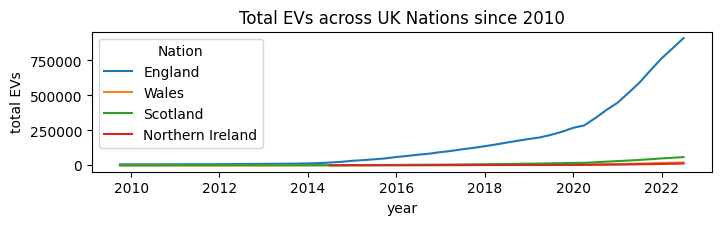

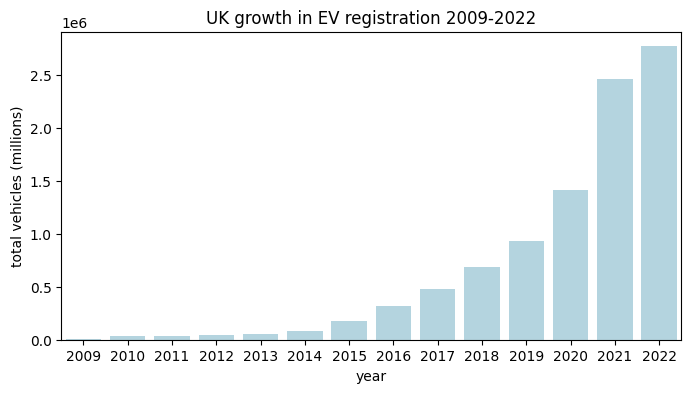

In [54]:
fig = plt.figure(figsize=(8,4))


#Total EVs across the nations by year
ax1 = fig.add_subplot(2,1,1)

ax1 = sns.lineplot(data=melted, x='quarter', y='total_vehicles', hue='ons_geography')
plt.title('Total EVs across UK Nations since 2010')
plt.xlabel('year')
plt.ylabel('total EVs')
plt.legend(title='Nation')

plt.show()

ax2= fig.add_subplot(2,2,1)

melted['year'] = melted['quarter'].dt.year

#Total EVs across the UK by year
fig = plt.figure(figsize=(8,4))

grouped_years = melted.groupby('year')['total_vehicles'].sum().reset_index()

ax2 = sns.barplot(data=grouped_years, x='year', y='total_vehicles', color='lightblue')
plt.ylabel('total vehicles (millions)')
plt.title('UK growth in EV registration 2009-2022')

plt.show()

We can see that England is by far the greatest user of electric vehicles of the UK nations. This seems natural as it is also the most populous nation by a long way. 

What is interesting in the top graphic is that the pronounced increase in EV registration in England in early 2020 was not as clearly felt in other UK nations, except perhaps in Scotland.

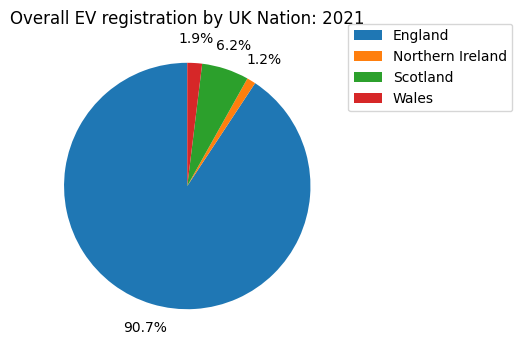

In [20]:
#Proportion of EVs in total across all nations in 2021 - the most recent year for which we have a full year of data
fig = plt.figure(figsize=(8,4))

evs_sum = melted[melted['quarter'] == '2021'].groupby('ons_geography')['total_vehicles'].sum()

labels=['England','Northern Ireland','Scotland','Wales']

ax2 = plt.pie(evs_sum, autopct='%1.1f%%'
              , startangle=90
              , pctdistance=1.2)
plt.title('Overall EV registration by UK Nation: 2021')
plt.legend(labels=labels, bbox_to_anchor=(1, 1.05))

plt.show()

Just confirming the scale of the difference between English EV registration and other nations. England accounts for 9 in 10 EVs!

We'll next take a look at the year-on-year percentage change in growth across the UK

In [29]:
#Going to calculate the year-on-year percentage change in the EV fleet across the UK

grouped_years['prev_year'] = grouped_years['total_vehicles'].shift(periods=1)
grouped_years['pct_change_yoy'] = 100*(grouped_years['total_vehicles']-grouped_years['prev_year'])/grouped_years['total_vehicles']

In [30]:
grouped_years

,year,total_vehicles,prev_year,pct_change_yoy
0,2009,7889.00,NaN,NaN
1,2010,31967.00,7889.00,75.32
2,2011,34726.00,31967.00,7.95
3,2012,40298.00,34726.00,13.83
4,2013,50133.00,40298.00,19.62
5,2014,83552.00,50133.00,40.00
6,2015,180448.00,83552.00,53.70
7,2016,316187.00,180448.00,42.93
8,2017,481690.00,316187.00,34.36
9,2018,687508.00,481690.00,29.94


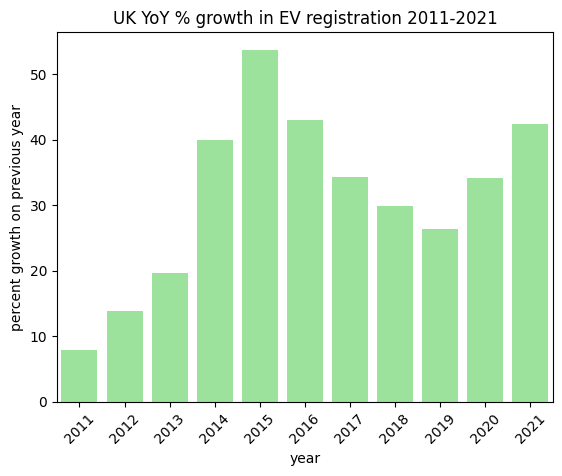

In [47]:
#Excluding 2009 and 2010. 2009 had just one quarter of data, which has inflated 2010's pct growth figure.

ax2 = sns.barplot(data=grouped_years[(grouped_years['year'] > 2010) & (grouped_years['year'] < 2022)]
                  , x='year'
                  , y='pct_change_yoy'
                  , color='lightgreen')
plt.ylabel('percent growth on previous year')
plt.xticks(rotation=45)
plt.title('UK YoY % growth in EV registration 2011-2021')

plt.show()

We see a large uptake in EVs betwen 2013 and 2015, which then declined steadily until reversing in 2020. 

A quick Google reveals this is change around 2020 was part of a global trend (read about it [here](https://www.theguardian.com/environment/2021/jan/19/global-sales-of-electric-cars-accelerate-fast-in-2020-despite-covid-pandemic)). 

New and more numerous models of EVs were coming on the market ([this is also true of 2014](https://www.theguardian.com/environment/2014/oct/07/uk-electric-car-sales-surge-in-2014)), and it was in 2020 that the UK government announced plans to [ban the sale of new fossil-fuel based cars by 2030](https://www.gov.uk/government/news/government-takes-historic-step-towards-net-zero-with-end-of-sale-of-new-petrol-and-diesel-cars-by-2030). This move could have put the idea of buying an EV at the front of motorists minds, when considering their next purchase.


<b>Next: look at the market share between the different EV types over time. Taa!</b>